This notebook contains the analysis and plots for the non-linear system generated by transforming the linear system using a diffeomorphism.

In [3]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%autoreload 2

from koopmaneigen.koopman_eigensolver import KoopmanEigenSolvers
from koopmaneigen.linearsystemcontinuous import Linear2dSystemContinuous
from koopmaneigen.koopman_eigensolver_dmd import KoopmanEigenSolversDMD
from datafold.pcfold import GaussianKernel, TSCDataFrame


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as ln

from datafold.appfold import EDMD
from datafold.dynfold import DMDFull
from datafold.dynfold.transform import TSCPolynomialFeatures, TSCRadialBasis

In [5]:
import ipynbname
import os
nb_fname = ipynbname.name()
nb_path = ipynbname.path()
nb_fname

if not os.path.exists(f"plots/{nb_fname}"):
    os.makedirs(f"plots/{nb_fname}")


In [6]:
plt.rcParams['text.usetex'] = True #
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

In [7]:
A = np.array([[-0.9, 0.1], [0, -0.8]])

eigvalue_i = -0.9
eigvalue_j = -0.8

V = np.array([[1, 1/np.sqrt(2)], [0, 1/np.sqrt(2)]])
V_inv = np.array([[1, -1], [0, np.sqrt(2)]])

assert np.isclose(V@V_inv, np.eye(2)).all()
assert np.isclose(V_inv@V, np.eye(2)).all()
assert np.isclose(A@V, V@np.diag([eigvalue_i, eigvalue_j])).all()

def eigenfunction_i(x,y):
    return (x-y)/np.sqrt(2)

def eigenfunction_j(x,y):
    return y    

In [8]:
t_eval = np.linspace(0, 0.4, 21)
t_sample = 0.4/(t_eval.shape[0]-1)
t_sample


0.02

In [9]:
np.random.seed(24)
# B = np.random.rand(2,2)
B = np.array([[-0.9, 0.1], [0, -0.8]])
# eps = 1e-3
# A = np.eye(2) + eps * B
A = B

In [10]:
eigs_A, eigvecs_A = np.linalg.eig(A.T)
eigs_A

array([-0.8, -0.9])

In [11]:
eigvecs_A

array([[ 0.        ,  0.70710678],
       [ 1.        , -0.70710678]])

In [12]:
np.exp(eigs_A*t_sample)

array([0.98412732, 0.98216103])

In [13]:
linear_system_c = Linear2dSystemContinuous(A, eig_i=eigs_A[0], eig_j=eigs_A[1], t_sample=t_sample, 
                                           eigenfunction_i=None,eigenfunction_j=None)

In [14]:
initial_conditions = np.array(
    np.meshgrid(np.linspace(0, 2, 30), np.linspace(0, 2, 30))
).T.reshape(-1, 2)

tsc_data = linear_system_c.sample_system(initial_conditions)
print(f"time delta: {tsc_data.delta_time}")
print(f"#time series: {tsc_data.n_timeseries}")
print(f"#time steps per time series: {tsc_data.n_timesteps}")
print(f"(n_samples, n_features): {tsc_data.shape}")
print(f"time interval {tsc_data.time_interval()}")
print(f"Same time values: {tsc_data.is_same_time_values()}")
print("")
print("Data snippet:")
tsc_data.head()

time delta: 0.02
#time series: 900
#time steps per time series: 2
(n_samples, n_features): (1800, 2)
time interval (0.0, 0.02)
Same time values: True

Data snippet:


feature        x1        x2
ID time                    
0  0.00  0.000000  0.000000
   0.02  0.000000  0.000000
1  0.00  0.000000  0.068966
   0.02  0.000136  0.067871
2  0.00  0.000000  0.137931

In [15]:
# define diffeomorphism
def diffeo(x):
#     return x**2
    return np.log(np.exp(x) + 1)

In [16]:
tsc_data_nonlin = diffeo(tsc_data)
tsc_data_nonlin.shape

(1800, 2)

In [17]:
tsc_data_nonlin.max(), tsc_data_nonlin.min()

(feature
 x1    2.126928
 x2    2.126928
 dtype: float64,
 feature
 x1    0.693147
 x2    0.693147
 dtype: float64)

In [18]:
t_eval = np.linspace(0, 0.4, 21)
t_sample = 0.4/(t_eval.shape[0]-1)

dict_step = [
    (
        "polynomial",
        TSCPolynomialFeatures(degree=6),
    )
]

edmd_poly = EDMD(dict_steps=dict_step, include_id_state=True).fit(X=tsc_data_nonlin)
edmd_poly_values = edmd_poly.predict(tsc_data_nonlin.initial_states())

edmd_poly_values_oos = edmd_poly.predict(diffeo(np.array([0.5, 0.5])), time_values=np.linspace(0, 2, 100))

In [19]:
edmd_poly.koopman_eigenvalues

0     0.999890+0.000000j
1     0.982105+0.000050j
2     0.982105-0.000050j
3     0.964962+0.000000j
4     0.964147+0.000000j
5     0.959679+0.000000j
6     0.946245+0.000000j
7     0.943492+0.002572j
8     0.943492-0.002572j
9     0.932403+0.000000j
10    0.925536+0.000000j
11    0.919982+0.000000j
12    0.918535+0.003484j
13    0.918535-0.003484j
14    0.905194+0.000000j
15    0.896782+0.000000j
16    0.896443+0.000000j
17    0.891676+0.010954j
18    0.891676-0.010954j
19    0.888832+0.007823j
20    0.888832-0.007823j
21    0.888279+0.011410j
22    0.888279-0.011410j
23    0.887018+0.000185j
24    0.887018-0.000185j
25    0.875416+0.005260j
26    0.875416-0.005260j
Name: evals, dtype: complex128

In [20]:
np.exp(eigs_A * t_sample)

array([0.98412732, 0.98216103])

In [21]:
eigs_2 = []
for (m,n) in [(i,0) for i in range(0,6)] + [(0,i) for i in range(1,6)]:
    eigs_2.append((np.exp(eigs_A[0] * t_sample*m) * np.exp(eigs_A[1] * t_sample*n)))

In [22]:
tol = 1e-4
mn_dict = {}
for m in range(0,11):
    for n in range(0,11):
        eig_mn = (np.exp(eigs_A[0] * t_sample*m) * np.exp(eigs_A[1] * t_sample*n))
        match = []
        for i, eig in enumerate(edmd_poly.koopman_eigenvalues):
            if np.abs(eig.real - eig_mn) < tol:
                match.append(i)
        if len(match)>0:
            mn_dict[f"m: {m}, n: {n}"] = match

In [23]:
mn_dict

{'m: 0, n: 1': [1, 2], 'm: 1, n: 3': [9], 'm: 3, n: 4': [23, 24]}

/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


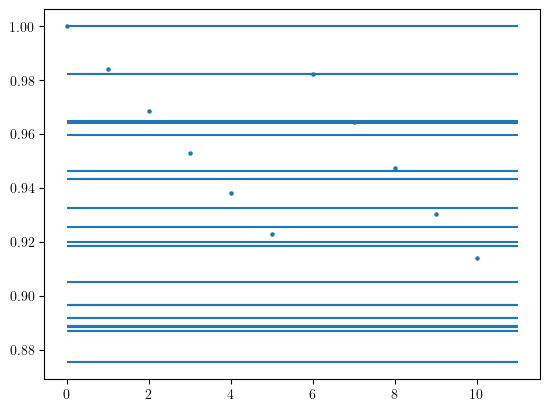

In [24]:
plt.scatter(np.array(range(len(eigs_2))), eigs_2, s=5)
plt.hlines(edmd_poly.koopman_eigenvalues, 0, len(eigs_2))

In [25]:
# function to give a score for out of sample EDMD predictions
def evaluate_edmd(edmd, t_eval, n_trajectories=50):
    initial_conditions = np.random.rand(n_trajectories,2) * 2
  
    error_x1 = []
    error_x2 = []
    for ic in initial_conditions:
        predicted = edmd.predict(diffeo(ic), t_eval)
        ground_truth = diffeo(linear_system_c.generate_trajectory(ic, t_eval))

        error_x1.append(np.linalg.norm(np.array(predicted["x1"]).reshape(-1)-ground_truth["x1"]))
        error_x2.append(np.linalg.norm(np.array(predicted["x2"]).reshape(-1)-ground_truth["x2"]))

    return {"x1_error_mean": np.array(error_x1).mean(), 
            "x2_error_mean": np.array(error_x2).mean()}


In [26]:
t_eval.shape

(21,)

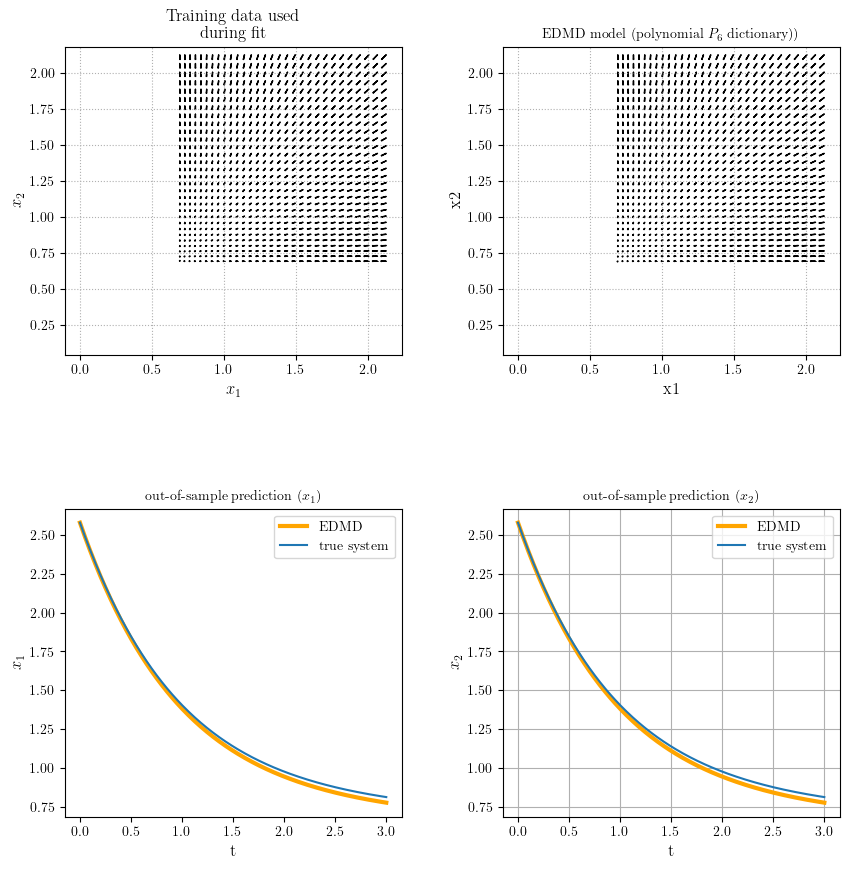

In [29]:
def include_arrow(ax, df, color="black", hw = 0.05):
        ax.arrow(
            df.iloc[-2, 0],
            df.iloc[-2, 1],
            dx=df.iloc[-1, 0] - df.iloc[-2, 0],
            dy=df.iloc[-1, 1] - df.iloc[-2, 1],
            color=color,
            head_width=hw,
        )
  
f, ax = plt.subplots(2, 2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.3)
for _id, df in tsc_data_nonlin.itertimeseries():
    ax[0][0].plot(df["x1"].to_numpy(), df["x2"].to_numpy(), 0.1, c="black", linewidth=0.5)
    include_arrow(ax[0][0], df, hw=0.005)
    
ax[0][0].set_title("Training data used\n during fit")
ax[0][0].set_xlabel(r"$x_1$", fontsize=12)
ax[0][0].set_ylabel(r"$x_2$",fontsize=12)
ax[0][0].axis("equal")
ax[0][0].grid(linestyle='dotted')

for _id, df in edmd_poly_values.itertimeseries():
    ax[0][1].plot(df["x1"].to_numpy(), df["x2"].to_numpy(), 0.1, c="black", linewidth=0.5)
    include_arrow(ax[0][1], df, hw=0.005)

ax[0][1].set_title("EDMD model (polynomial $P_6$ dictionary))", size=10)
ax[0][1].set_xlabel(r"$x_1$", fontsize=12)
ax[0][1].set_ylabel(r"$x_2$", fontsize=12)
ax[0][1].set_xlabel("x1")
ax[0][1].set_ylabel("x2")
ax[0][1].axis("equal")
ax[0][1].grid(linestyle='dotted')


# generate red "out-of-sample" prediction, for extra analysis below
# ax[0][1].plot(edmd_poly_values_oos["x1"], edmd_poly_values_oos["x2"], 0.1, c="red")
# include_arrow(ax[0][1], edmd_poly_values_oos, color="red", hw = 0.05)

# compare oos prediction
initial_condition = np.array([2.5,2.5])
t_eval = np.linspace(0, 3, 300)

ground_truth = diffeo(linear_system_c.generate_trajectory(initial_condition, t_eval))
predicted = edmd_poly.predict(diffeo(initial_condition), t_eval)

ax[1][0].plot(t_eval, predicted["x1"], c="orange", label="EDMD", linewidth=3)
ax[1][0].plot(t_eval, ground_truth.loc[:, "x1"], label="true system")

ax[1][0].set_title("out-of-sample prediction ($x_1$)", size=10)
ax[1][0].set_xlabel("t", fontsize=12)
ax[1][0].set_ylabel(r"$x_1$", fontsize=12)
ax[1][0].grid(linestyle='dotted')
ax[1][0].grid()
ax[1][0].legend()


ax[1][1].plot(t_eval, predicted["x2"], c="orange", label="EDMD", linewidth=3)
ax[1][1].plot(t_eval, ground_truth.loc[:, "x2"], label="true system")

ax[1][1].set_title("out-of-sample prediction ($x_2$)", size=10)
ax[1][1].set_xlabel("t", fontsize=12)
ax[1][1].set_ylabel("$x_2$", fontsize=12)
ax[1][1].grid()
ax[1][1].legend()

plt.savefig(f"plots/{nb_fname}/EDMD_P6_diffeo_linear_continuous_system.png", bbox_inches='tight', dpi=300)
plt.show()

In [30]:
t_eval = np.linspace(0, 3, 300)
evaluate_edmd(edmd_poly, t_eval)

{'x1_error_mean': 0.004144136597533058, 'x2_error_mean': 0.004098829623335492}

### Try with rbf dictionary basis

In [31]:
dict_step = [
        (
            "rbf",
            TSCRadialBasis(
                kernel=GaussianKernel(epsilon=0.17), center_type="initial_condition"
            ),
        )
    ]

    # Note that the "extended" part is in the transformations
edmd_rbf = EDMD(dict_steps=dict_step, include_id_state=True).fit(X=tsc_data_nonlin)
edmd_rbf_values = edmd_rbf.predict(
    tsc_data_nonlin.initial_states(), time_values=tsc_data_nonlin.time_values()
)

len_koopman_matrix = len(edmd_rbf.named_steps["dmd"].eigenvectors_right_)
print(f"shape of Koopman matrix: {len_koopman_matrix} x {len_koopman_matrix}")

/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/datafold/dynfold/dmd.py:1169: UserWarning: There are more observables than snapshots. The current implementation favors more snapshots than obserables. This may result in a bad computational performance.
  warnings.warn(
/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/datafold/dynfold/dmd.py:1187: UserWarning: Shift matrix (shape=(902, 902)) has not full rank (=60), falling back to least squares solution. The sum of residuals is: 0.0
  warnings.warn(


shape of Koopman matrix: 902 x 902


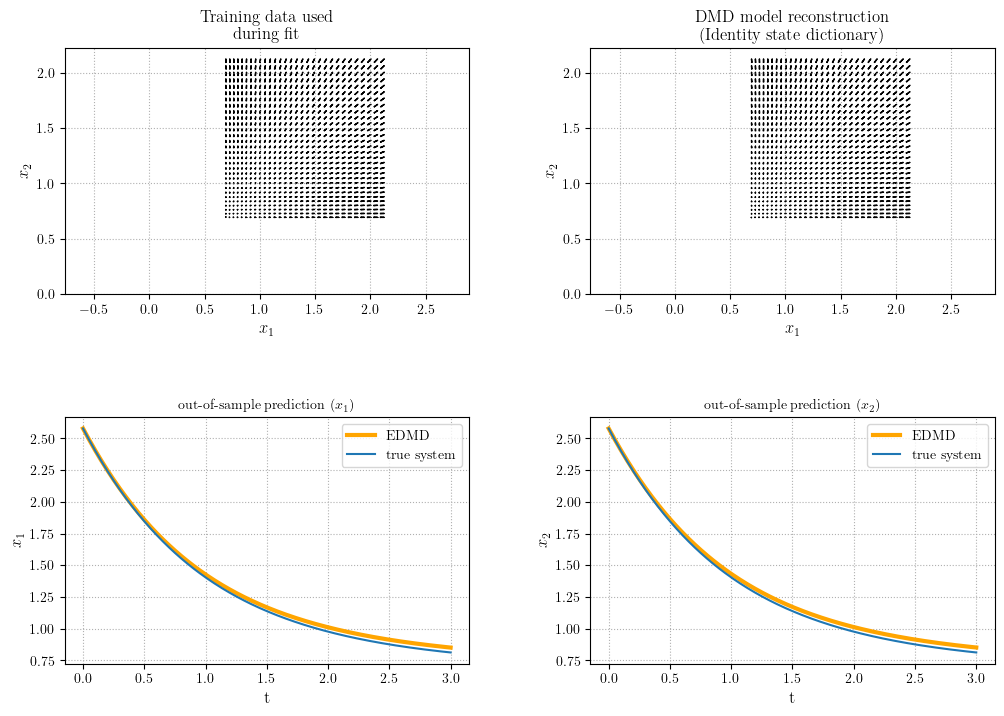

In [43]:
def include_arrow(ax, df, color="black", hw = 0.05):
        ax.arrow(
            df.iloc[-2, 0],
            df.iloc[-2, 1],
            dx=df.iloc[-1, 0] - df.iloc[-2, 0],
            dy=df.iloc[-1, 1] - df.iloc[-2, 1],
            color=color,
            head_width=hw,
        )
  
f, ax = plt.subplots(2, 2, figsize=(12, 8))
plt.subplots_adjust(hspace=0.5, wspace=0.3)
for _id, df in tsc_data_nonlin.itertimeseries():
    ax[0][0].plot(df["x1"].to_numpy(), df["x2"].to_numpy(), 0.1, c="black", linewidth=0.5)
    include_arrow(ax[0][0], df, hw=0.005)
    
ax[0][0].set_title("Training data used\n during fit")
ax[0][0].set_xlabel(r"$x_1$", fontsize=12)
ax[0][0].set_ylabel(r"$x_2$",fontsize=12)
ax[0][0].axis("equal")
ax[0][0].grid(linestyle='dotted')

for _id, df in edmd_rbf_values.itertimeseries():
    ax[0][1].plot(df["x1"].to_numpy(), df["x2"].to_numpy(), 0.1, c="black", linewidth=0.5)
    include_arrow(ax[0][1], df, hw=0.005)

ax[0][1].set_title("DMD model reconstruction\n(Identity state dictionary)")
ax[0][1].set_xlabel(r"$x_1$", fontsize=12)
ax[0][1].set_ylabel(r"$x_2$", fontsize=12)
ax[0][1].axis("equal")
ax[0][1].grid(linestyle='dotted')


# generate red "out-of-sample" prediction, for extra analysis below
# ax[0][1].plot(edmd_poly_values_oos["x1"], edmd_poly_values_oos["x2"], 0.1, c="red")
# include_arrow(ax[0][1], edmd_poly_values_oos, color="red", hw = 0.05)

# compare oos prediction
initial_condition = np.array([2.5,2.5])
t_eval = np.linspace(0, 3, 300)

ground_truth = diffeo(linear_system_c.generate_trajectory(initial_condition, t_eval))
predicted = edmd_rbf.predict(diffeo(initial_condition), t_eval)

ax[1][0].plot(t_eval, predicted["x1"], c="orange", label="EDMD", linewidth=3)
ax[1][0].plot(t_eval, ground_truth.loc[:, "x1"], label="true system")

ax[1][0].set_title("out-of-sample prediction ($x_1$)", size=10)
ax[1][0].set_xlabel("t", fontsize=12)
ax[1][0].set_ylabel(r"$x_1$", fontsize=12)
ax[1][0].grid(linestyle='dotted')
ax[1][0].legend()


ax[1][1].plot(t_eval, predicted["x2"], c="orange", label="EDMD", linewidth=3)
ax[1][1].plot(t_eval, ground_truth.loc[:, "x2"], label="true system")

ax[1][1].set_title("out-of-sample prediction ($x_2$)", size=10)
ax[1][1].set_xlabel("t", fontsize=12)
ax[1][1].set_ylabel("$x_2$", fontsize=12)
ax[1][1].grid(linestyle='dotted')
ax[1][1].legend()

# plt.savefig('plots/EDMD_diffeo_linear_continuous_system.png', bbox_inches='tight', dpi=300)
plt.show()

In [33]:
t_eval = np.linspace(0, 3, 300)
evaluate_edmd(edmd_rbf, t_eval)

{'x1_error_mean': 0.0022890939192763827,
 'x2_error_mean': 0.0024474813579733246}

In [34]:
tol = 1e-4
mn_dict = {}
for m in range(0,11):
    for n in range(0,11):
        eig_mn = (np.exp(eigs_A[0] * t_sample*m) * np.exp(eigs_A[1] * t_sample*n))
        match = []
        for i, eig in enumerate(edmd_rbf.koopman_eigenvalues):
            if np.abs(eig.real - eig_mn) < tol:
                match.append(i)
        if len(match)>0:
            mn_dict[f"m: {m}, n: {n}"] = match

In [35]:
mn_dict

{'m: 0, n: 0': [0],
 'm: 1, n: 7': [50, 51],
 'm: 4, n: 2': [33, 34],
 'm: 6, n: 1': [39, 40],
 'm: 8, n: 1': [52, 53]}

for epsilon_rbf in np.linspace(0.01,0.1,20):

    dict_step = [
        (
            "rbf",
            TSCRadialBasis(
                kernel=GaussianKernel(epsilon=epsilon_rbf), center_type="initial_condition"
            ),
        )
    ]

    # Note that the "extended" part is in the transformations
    edmd_rbf = EDMD(dict_steps=dict_step, include_id_state=True).fit(X=tsc_data_nonlin)
    t_eval = np.linspace(0, 3, 300)
    print(epsilon_rbf, evaluate_edmd(edmd_poly, t_eval))

### Try rbf with less basis functions

In [44]:
edmd_rbf.named_steps

{'rbf': TSCRadialBasis(center_type='fit_params', kernel=GaussianKernel(epsilon=0.3)),
 'dmd': DMDFull()}

In [45]:
tsc_data_nonlin.shape

(1800, 2)

In [46]:
#### do kmeans to choose rbf centers

In [47]:
from sklearn.cluster import KMeans

kmeans = KMeans(40, verbose=1, init='k-means++', n_init=1, random_state=11)
kmeans.fit(tsc_data_nonlin)
#def get_centers_knn():

identified_clusters = kmeans.fit_predict(tsc_data_nonlin)
identified_clusters
unique, counts = np.unique(identified_clusters, return_counts=True)

centers = kmeans.cluster_centers_
centers

Initialization complete
Iteration 0, inertia 19.615575932550865.
Iteration 1, inertia 17.361323796060887.
Iteration 2, inertia 16.908882556707226.
Iteration 3, inertia 16.68014162834802.
Iteration 4, inertia 16.559853025005545.
Iteration 5, inertia 16.52084908552135.
Iteration 6, inertia 16.48279281934743.
Iteration 7, inertia 16.448563572784206.
Iteration 8, inertia 16.430605274670196.
Iteration 9, inertia 16.40804715827547.
Iteration 10, inertia 16.358406477188698.
Iteration 11, inertia 16.329546497936235.
Iteration 12, inertia 16.295850465027257.
Iteration 13, inertia 16.27303306395883.
Iteration 14, inertia 16.25143728756492.
Iteration 15, inertia 16.235544011115085.
Iteration 16, inertia 16.218782052274967.
Iteration 17, inertia 16.205628909078044.
Iteration 18, inertia 16.192335484554857.
Iteration 19, inertia 16.183751347736237.
Iteration 20, inertia 16.16671605664406.
Iteration 21, inertia 16.15253054103543.
Iteration 22, inertia 16.14580294007684.
Iteration 23, inertia 16.1409

array([[2.03793207, 1.68647932],
       [0.9567148 , 1.38404143],
       [1.4733586 , 0.79102119],
       [0.77203342, 0.77077706],
       [1.15801762, 1.7600555 ],
       [1.4004365 , 1.28164688],
       [1.7387691 , 1.24239292],
       [2.01302942, 0.81561922],
       [0.95372292, 1.85159698],
       [1.30159153, 1.02335927],
       [1.59745718, 1.94548009],
       [0.76560537, 1.27377406],
       [1.80853901, 1.56762498],
       [1.14283819, 2.02625045],
       [2.01363476, 1.12116964],
       [1.16047713, 1.23441627],
       [1.79395159, 0.99025636],
       [1.23742317, 0.7807487 ],
       [1.8279767 , 1.83108737],
       [1.36908588, 1.54533451],
       [1.53882372, 1.04433919],
       [0.75995861, 2.01767822],
       [1.09151797, 0.98227342],
       [1.58624926, 1.69326735],
       [1.99826286, 1.3883056 ],
       [1.60224835, 1.43443422],
       [1.37033868, 1.81065385],
       [0.7619088 , 1.76238394],
       [0.94438767, 1.62466019],
       [1.72630782, 0.78144174],
       [0.

In [48]:
centers.shape

(40, 2)

In [49]:
dict_step = [
        (
            "rbf",
            TSCRadialBasis(
                kernel=GaussianKernel(epsilon=0.3), center_type="fit_params",
            ),
        )
    ]

    # Note that the "extended" part is in the transformations
edmd_rbf = EDMD(dict_steps=dict_step, include_id_state=True).fit(X=tsc_data_nonlin, 
                                                                 rbf__centers=centers)

/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/datafold/dynfold/dmd.py:1187: UserWarning: Shift matrix (shape=(42, 42)) has not full rank (=40), falling back to least squares solution. The sum of residuals is: 0.0
  warnings.warn(


In [50]:
t_eval = np.linspace(0, 3, 300)
evaluate_edmd(edmd_rbf, t_eval)

{'x1_error_mean': 0.0023619150407707575, 'x2_error_mean': 0.002872575176952261}

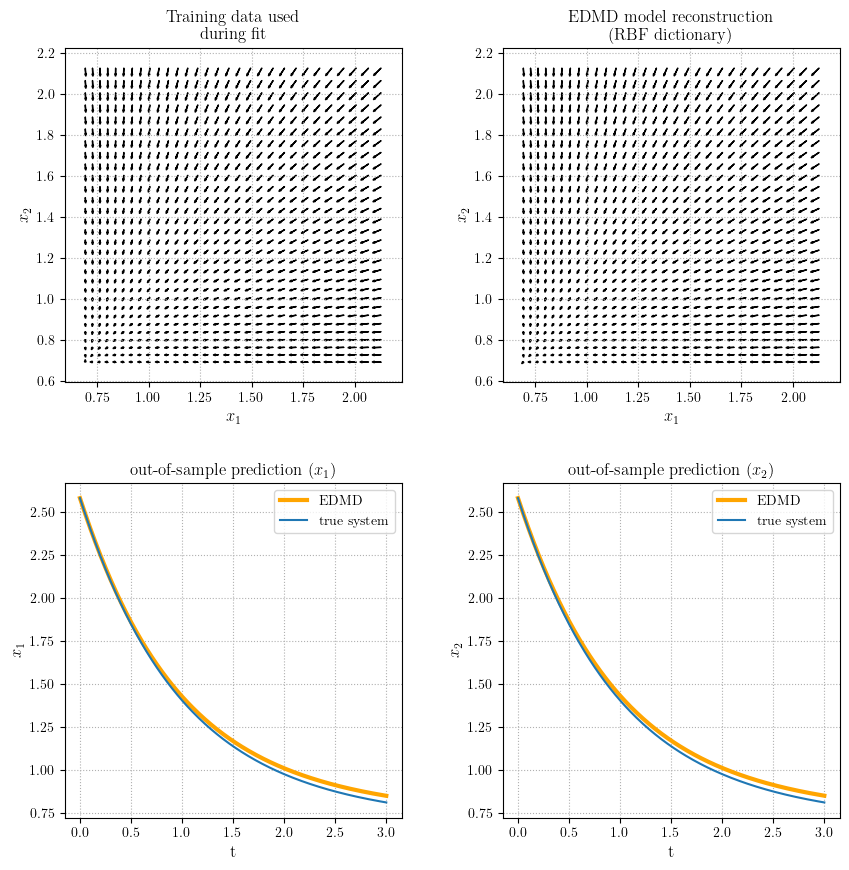

In [75]:
def include_arrow(ax, df, color="black", hw = 0.05):
        ax.arrow(
            df.iloc[-2, 0],
            df.iloc[-2, 1],
            dx=df.iloc[-1, 0] - df.iloc[-2, 0],
            dy=df.iloc[-1, 1] - df.iloc[-2, 1],
            color=color,
            head_width=hw,
        )
  
f, ax = plt.subplots(2, 2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
for _id, df in tsc_data_nonlin.itertimeseries():
    ax[0][0].plot(df["x1"].to_numpy(), df["x2"].to_numpy(), 0.1, c="black", linewidth=0.5)
    include_arrow(ax[0][0], df, hw=0.008)
    
ax[0][0].set_title("Training data used\n during fit")
ax[0][0].set_xlabel(r"$x_1$", fontsize=12)
ax[0][0].set_ylabel(r"$x_2$",fontsize=12)
ax[0][0].set_xlim(xmin = tsc_data_nonlin["x1"].min()[0] - 0.1, xmax=tsc_data_nonlin["x1"].max()[0] + 0.1)
ax[0][0].set_ylim(ymin = tsc_data_nonlin["x2"].min()[0] - 0.1, ymax=tsc_data_nonlin["x2"].max()[0] + 0.1)
# ax[0][0].axis("equal")
ax[0][0].grid(linestyle='dotted')

for _id, df in edmd_rbf_values.itertimeseries():
    ax[0][1].plot(df["x1"].to_numpy(), df["x2"].to_numpy(), 0.1, c="black", linewidth=0.5)
    include_arrow(ax[0][1], df, hw=0.008)

ax[0][1].set_title("EDMD model reconstruction\n(RBF dictionary)")
ax[0][1].set_xlabel(r"$x_1$", fontsize=12)
ax[0][1].set_ylabel(r"$x_2$", fontsize=12)
ax[0][1].set_xlim(xmin = edmd_rbf_values["x1"].min()[0] - 0.1, xmax=edmd_rbf_values["x1"].max()[0] + 0.1)
ax[0][1].set_ylim(ymin = edmd_rbf_values["x2"].min()[0] - 0.1, ymax=edmd_rbf_values["x2"].max()[0] + 0.1)
# ax[0][1].axis("equal")
ax[0][1].grid(linestyle='dotted')


# generate red "out-of-sample" prediction, for extra analysis below
# ax[0][1].plot(edmd_poly_values_oos["x1"], edmd_poly_values_oos["x2"], 0.1, c="red")
# include_arrow(ax[0][1], edmd_poly_values_oos, color="red", hw = 0.05)

# compare oos prediction
initial_condition = np.array([2.5,2.5])
t_eval = np.linspace(0, 3, 300)

ground_truth = diffeo(linear_system_c.generate_trajectory(initial_condition, t_eval))
predicted = edmd_rbf.predict(diffeo(initial_condition), t_eval)

ax[1][0].plot(t_eval, predicted["x1"], c="orange", label="EDMD", linewidth=3)
ax[1][0].plot(t_eval, ground_truth.loc[:, "x1"], label="true system")

ax[1][0].set_title("out-of-sample prediction ($x_1$)")
ax[1][0].set_xlabel("t", fontsize=12)
ax[1][0].set_ylabel(r"$x_1$", fontsize=12)
ax[1][0].grid(linestyle='dotted')
ax[1][0].legend()


ax[1][1].plot(t_eval, predicted["x2"], c="orange", label="EDMD", linewidth=3)
ax[1][1].plot(t_eval, ground_truth.loc[:, "x2"], label="true system")

ax[1][1].set_title("out-of-sample prediction ($x_2$)")
ax[1][1].set_xlabel("t", fontsize=12)
ax[1][1].set_ylabel("$x_2$", fontsize=12)
ax[1][1].grid(linestyle='dotted')
ax[1][1].legend()


plt.savefig(f"plots/{nb_fname}/EDMD_rbf_40_diffeo_linear_continuous_system.pdf", bbox_inches='tight', dpi=300)
plt.show()

In [76]:
edmd_rbf.koopman_eigenvalues

0     9.999345e-01+0.000000e+00j
1     9.819818e-01+3.169733e-04j
2     9.819818e-01-3.169733e-04j
3     9.716880e-01+0.000000e+00j
4     9.613189e-01+0.000000e+00j
5     9.590856e-01+1.174639e-02j
6     9.590856e-01-1.174639e-02j
7     9.560610e-01+3.288086e-02j
8     9.560610e-01-3.288086e-02j
9     9.436921e-01+3.746936e-03j
10    9.436921e-01-3.746936e-03j
11    9.408284e-01+2.258207e-02j
12    9.408284e-01-2.258207e-02j
13    9.342349e-01+5.314323e-02j
14    9.342349e-01-5.314323e-02j
15    9.294443e-01+2.835104e-02j
16    9.294443e-01-2.835104e-02j
17    9.289919e-01+7.828018e-02j
18    9.289919e-01-7.828018e-02j
19    9.253228e-01+3.683602e-02j
20    9.253228e-01-3.683602e-02j
21    9.239630e-01+0.000000e+00j
22    9.101395e-01+7.986067e-02j
23    9.101395e-01-7.986067e-02j
24    9.099198e-01+4.539766e-02j
25    9.099198e-01-4.539766e-02j
26    9.000479e-01+9.108203e-02j
27    9.000479e-01-9.108203e-02j
28    8.966406e-01+6.119983e-02j
29    8.966406e-01-6.119983e-02j
30    8.94

In [77]:
np.exp(eigs_A * t_sample)

array([0.98412732, 0.98216103])

In [78]:
tol = 1e-5
mn_dict = {}
for m in range(0,15):
    for n in range(0,15):
        eig_mn = (np.exp(eigs_A[0] * t_sample*m) * np.exp(eigs_A[1] * t_sample*n))
        match = []
        for i, eig in enumerate(edmd_rbf.koopman_eigenvalues):
            if np.abs(eig.real - eig_mn) < tol:
                match.append(i)
        if len(match)>0:
            mn_dict[f"m: {m}, n: {n}"] = match

mn_dict

{}

### Create koopman eigen object

In [79]:
koopman_eigen_edmd = KoopmanEigenSolvers(edmd_poly, tsc_data_nonlin, include_id_state=True)
print("shape of koopman matrix: ", koopman_eigen_edmd.koopman_matrix.shape)

shape of koopman matrix:  (27, 27)


In [80]:
koopman_eigen_rbf = KoopmanEigenSolvers(edmd_rbf, tsc_data_nonlin, include_id_state=True)
print("shape of koopman matrix: ", koopman_eigen_rbf.koopman_matrix.shape)

shape of koopman matrix:  (42, 42)


/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/datafold/dynfold/dmd.py:1187: UserWarning: Shift matrix (shape=(42, 42)) has not full rank (=40), falling back to least squares solution. The sum of residuals is: 0.0
  warnings.warn(


In [81]:
koopman_eigen_rbf.left_koopman_eigvals

array([ 9.99934503e-01+0.j        ,  9.81981812e-01+0.00031697j,
        9.81981812e-01-0.00031697j,  9.71688033e-01+0.j        ,
        9.61318889e-01+0.j        ,  9.59085571e-01+0.01174639j,
        9.59085571e-01-0.01174639j,  9.56060982e-01+0.03288086j,
        9.56060982e-01-0.03288086j,  9.43692058e-01+0.00374694j,
        9.43692058e-01-0.00374694j,  9.40828449e-01+0.02258207j,
        9.40828449e-01-0.02258207j,  9.34234921e-01+0.05314323j,
        9.34234921e-01-0.05314323j,  9.29444311e-01+0.02835104j,
        9.29444311e-01-0.02835104j,  9.28991924e-01+0.07828018j,
        9.28991924e-01-0.07828018j,  9.25322772e-01+0.03683602j,
        9.25322772e-01-0.03683602j,  9.23963013e-01+0.j        ,
        9.10139521e-01+0.07986067j,  9.10139521e-01-0.07986067j,
        9.09919835e-01+0.04539766j,  9.09919835e-01-0.04539766j,
        9.00047885e-01+0.09108203j,  9.00047885e-01-0.09108203j,
        8.96640605e-01+0.06119983j,  8.96640605e-01-0.06119983j,
        8.94946505e-01+0.

/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/matplotlib/contour.py:1454: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = float(z.max())
/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/matplotlib/contour.py:1455: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = float(z.min())
/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/numpy/ma/core.py:2829: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


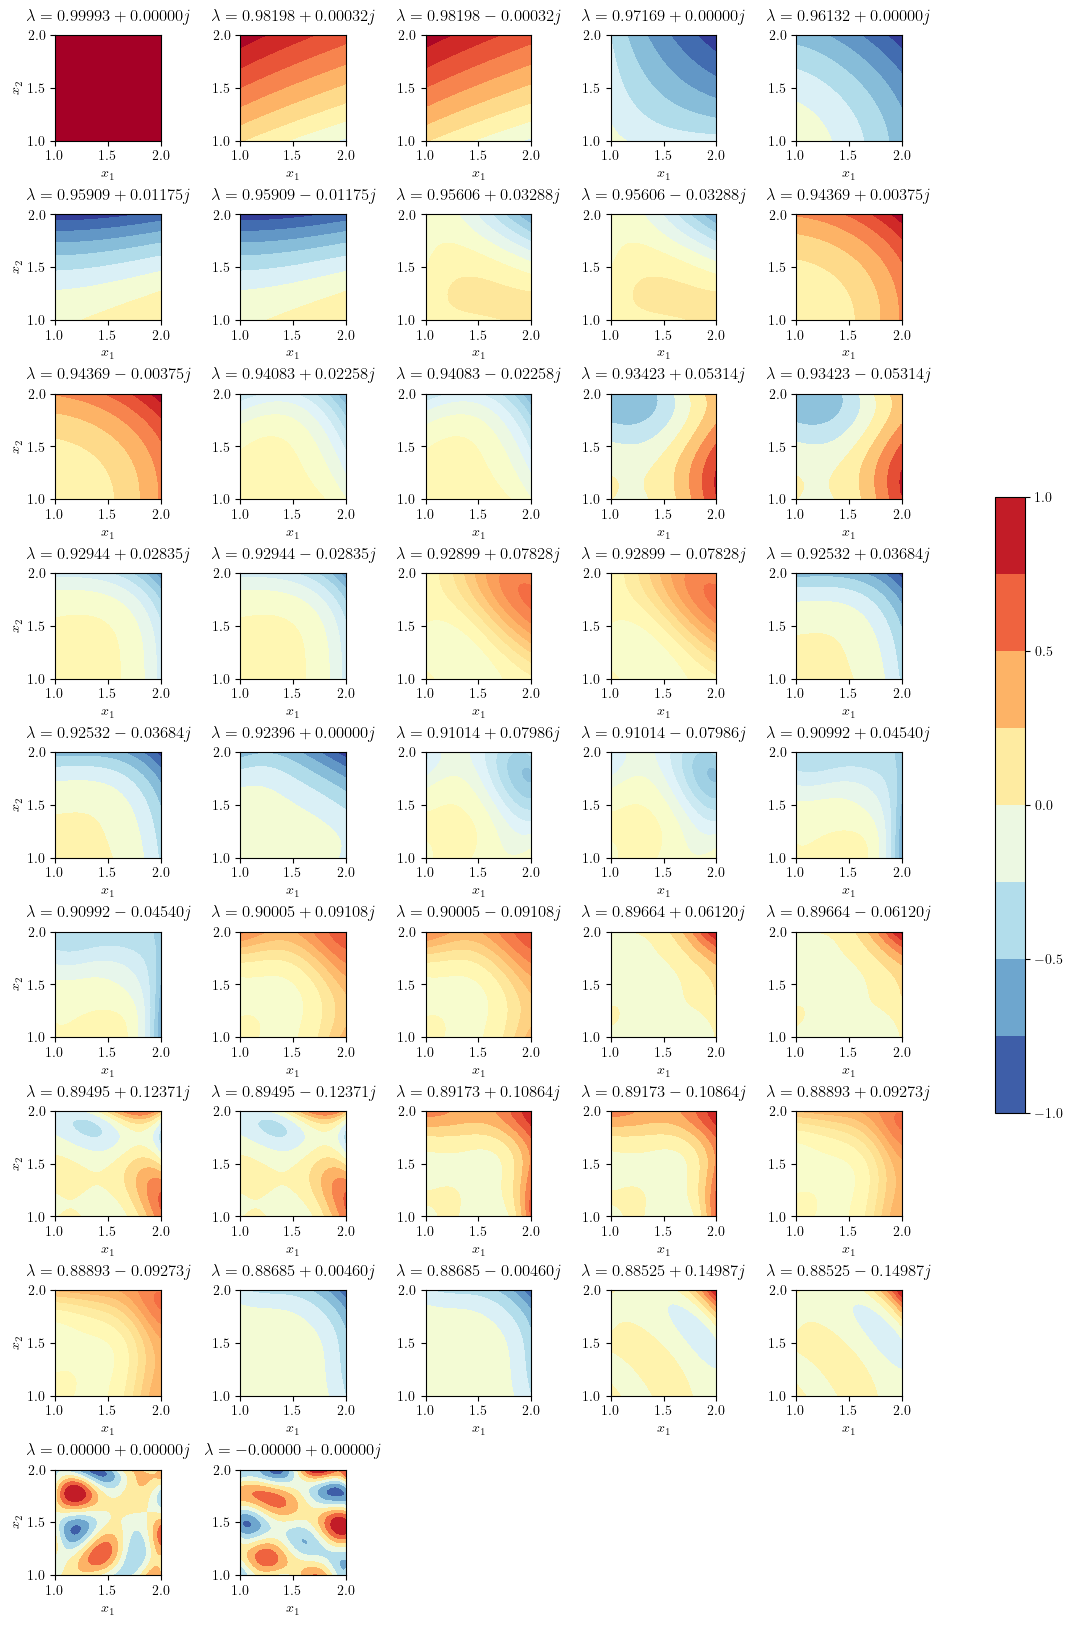

In [271]:
n_plot_dim = int(np.ceil(koopman_eigen_rbf.koopman_matrix.shape[0]/5))
f, ax = plt.subplots(n_plot_dim, 5, figsize=(15, 20))
f.delaxes(ax[n_plot_dim-1, 4])
f.delaxes(ax[n_plot_dim-1, 3])
f.delaxes(ax[n_plot_dim-1, 2])

plt.subplots_adjust(hspace=0.7)

x = np.linspace(1, 2, 100)
y = np.linspace(1, 2, 100)
X, Y = np.meshgrid(x, y)
x_flat = np.array([X.flatten(), Y.flatten()]).T

koopman_eigenfunctions_eval = koopman_eigen_rbf.eigenfunction_left(koopman_eigen_rbf.left_koopman_eigvecs)(x_flat)

for i in range(koopman_eigenfunctions_eval.shape[1]):
    
    Z = koopman_eigenfunctions_eval[:, i]
    Z = Z/np.max(np.abs(Z))
    
    h = ax[int(i/5)][i%5].contourf(X, Y, np.array(Z).reshape(100,100), cmap='RdYlBu_r', vmin=-1, vmax=1)
    eig = koopman_eigen_rbf.left_koopman_eigvals[i]

    ax[int(i/5)][i%5].set_title(f"$\lambda = {eig:.5f}$", fontsize=12, pad=10)
    ax[int(i/5)][i%5].set_aspect("equal")
    ax[int(i/5)][i%5].set_xlabel("$x_1$", fontsize=10)
    if i%5==0:
        ax[int(i/5)][i%5].set_ylabel("$x_2$", fontsize=10)
    ax[int(i/5)][i%5].set_xticks([ax[int(i/5)][i%5].get_xlim()[0], 1.5, ax[int(i/5)][i%5].get_xlim()[1]])
    ax[int(i/5)][i%5].set_yticks([ax[int(i/5)][i%5].get_ylim()[0], 1.5, ax[int(i/5)][i%5].get_ylim()[1]])

cbar = f.colorbar(h, ax=ax.ravel().tolist(), shrink=0.4, pad=0.08)
cbar.ax.tick_params(labelsize=10)
cbar.set_ticks(np.arange(-1, 1.1, 0.5))

plt.savefig(f"plots/{nb_fname}/EDMD_rbf_40_diffeo_linear_continuous_system_eigenfunctions.pdf", 
            bbox_inches='tight', dpi=300)
plt.show()

In [83]:
edmd_rbf.koopman_eigenvalues

0     9.999345e-01+0.000000e+00j
1     9.819818e-01+3.169733e-04j
2     9.819818e-01-3.169733e-04j
3     9.716880e-01+0.000000e+00j
4     9.613189e-01+0.000000e+00j
5     9.590856e-01+1.174639e-02j
6     9.590856e-01-1.174639e-02j
7     9.560610e-01+3.288086e-02j
8     9.560610e-01-3.288086e-02j
9     9.436921e-01+3.746936e-03j
10    9.436921e-01-3.746936e-03j
11    9.408284e-01+2.258207e-02j
12    9.408284e-01-2.258207e-02j
13    9.342349e-01+5.314323e-02j
14    9.342349e-01-5.314323e-02j
15    9.294443e-01+2.835104e-02j
16    9.294443e-01-2.835104e-02j
17    9.289919e-01+7.828018e-02j
18    9.289919e-01-7.828018e-02j
19    9.253228e-01+3.683602e-02j
20    9.253228e-01-3.683602e-02j
21    9.239630e-01+0.000000e+00j
22    9.101395e-01+7.986067e-02j
23    9.101395e-01-7.986067e-02j
24    9.099198e-01+4.539766e-02j
25    9.099198e-01-4.539766e-02j
26    9.000479e-01+9.108203e-02j
27    9.000479e-01-9.108203e-02j
28    8.966406e-01+6.119983e-02j
29    8.966406e-01-6.119983e-02j
30    8.94

In [84]:
def diffeo_inv(x):
#     return x**(1/2)
    return np.log(np.exp(x) - 1)

### explicit eigenfunction calculation and checking if they are eigenfunctions for non lin system using euler integration

In [85]:
h=0.0001

In [86]:
x_euler = np.apply_along_axis(lambda x: linear_system_c.euler_method(x, t_sample, h=h), 1, x_flat)
y_euler = diffeo(x_euler)

np.linalg.norm(eigvecs_A[:,0]@diffeo_inv(y_euler).T - 
               np.exp(eigs_A[0]*t_sample) * eigvecs_A[:,0]@diffeo_inv(diffeo(x_flat)).T)/np.sqrt(x_flat.shape[0])



0.00011935277328651167

In [87]:
np.linalg.norm(eigvecs_A[:,0]@x_euler.T - 
               np.exp(eigs_A[0]*t_sample) * eigvecs_A[:,0]@x_flat.T)/np.sqrt(x_flat.shape[0])

0.00011935277328653992

In [88]:
np.linalg.norm(eigvecs_A[:,1]@diffeo_inv(y_euler).T - 
               np.exp(eigs_A[1]*t_sample) * eigvecs_A[:,1]@diffeo_inv(diffeo(x_flat)).T)/np.sqrt(x_flat.shape[0])



2.5544075138147553e-05

In [89]:
np.exp(eigs_A*t_sample)

array([0.98412732, 0.98216103])

In [90]:
koopman_eigen_edmd.left_koopman_eigvals

array([0.99988991+0.00000000e+00j, 0.9821053 +5.04762875e-05j,
       0.9821053 -5.04762875e-05j, 0.96496174+0.00000000e+00j,
       0.96414705+0.00000000e+00j, 0.95967863+0.00000000e+00j,
       0.94624456+0.00000000e+00j, 0.94349177+2.57159111e-03j,
       0.94349177-2.57159111e-03j, 0.93240332+0.00000000e+00j,
       0.92553623+0.00000000e+00j, 0.91998156+0.00000000e+00j,
       0.91853524+3.48443336e-03j, 0.91853524-3.48443336e-03j,
       0.90519437+0.00000000e+00j, 0.89678161+0.00000000e+00j,
       0.89644338+0.00000000e+00j, 0.89167616+1.09538737e-02j,
       0.89167616-1.09538737e-02j, 0.88883194+7.82327705e-03j,
       0.88883194-7.82327705e-03j, 0.88827852+1.14104983e-02j,
       0.88827852-1.14104983e-02j, 0.88701843+1.85048547e-04j,
       0.88701843-1.85048547e-04j, 0.87541643+5.25993045e-03j,
       0.87541643-5.25993045e-03j])

### checking if some eigenfunctions found by EDMD are close to explicitly known eigenfunctions

In [91]:
eigvecs_A

array([[ 0.        ,  0.70710678],
       [ 1.        , -0.70710678]])

p = np.log(koopman_eigen_edmd.left_koopman_eigvals[10])/(eigs_A[0] * t_sample)

In [92]:
np.exp(eigs_A[0] * t_sample*2) - edmd_poly.koopman_eigenvalues[0]

(-0.03138332815218159+0j)

In [93]:
mn_dict

{}

In [94]:
x = np.linspace(1,2, 100)
y = np.linspace(1,2, 100)
X, Y = np.meshgrid(x, y)
x_flat = np.array([X.flatten(), Y.flatten()]).T

In [95]:
y_flat = diffeo(x_flat)

In [96]:
eigfunc1 = eigvecs_A[:,0]@diffeo_inv(x_flat).T
eigfunc2 = eigvecs_A[:,1]@diffeo_inv(x_flat).T
eigfunc1.shape, eigfunc2.shape

koopman_eigenfunctions_eval = koopman_eigen_edmd.eigenfunction_left(koopman_eigen_edmd.left_koopman_eigvecs)(x_flat)
koopman_eigenfunctions_eval.shape

np.linalg.norm(koopman_eigenfunctions_eval[:,9] - ((eigfunc1**1) * (eigfunc2 **3 )))/np.sqrt(x_flat.shape[0])

0.3630425603664756

In [97]:
np.linalg.norm(koopman_eigenfunctions_eval[:,2] -eigfunc2)/np.sqrt(x_flat.shape[0])

0.32005253852007476

In [98]:
def compute_c_error(Z, Z_l):
    tol = 1e-16
    Z = Z.flatten()
    Z_l = Z_l.flatten()
    z_0 = np.logical_or((np.abs(Z) <tol), (np.abs(Z_l) <tol))

    unique_values, value_counts = np.unique(Z[~z_0]/ Z_l[~z_0], return_counts=True)
    print(value_counts.max())
    
    # Get the mode value and count
    c_mode = unique_values[np.argmax(value_counts)]
#     print(c_mode)
    c_mode_count = value_counts[np.argmax(value_counts)]
    
    error = np.linalg.norm(Z  - c_mode*Z_l)
    return error

In [99]:
np.linalg.matrix_rank(np.column_stack((eigfunc2, koopman_eigenfunctions_eval[:,2])))

2

/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/matplotlib/contour.py:1454: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = float(z.max())
/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/matplotlib/contour.py:1455: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = float(z.min())
/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/numpy/ma/core.py:2829: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


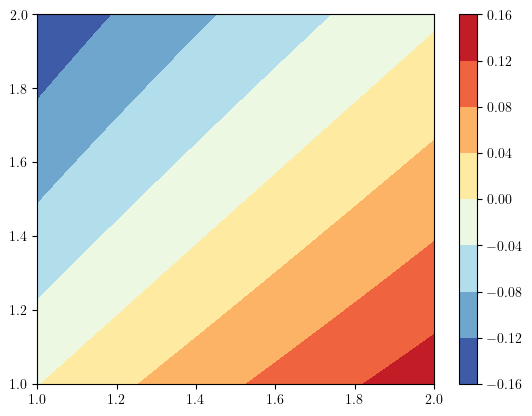

In [100]:
Z = koopman_eigenfunctions_eval[:,2]
Z = Z.reshape(100,100)
# Z = Z/np.max(np.abs(Z))
h = plt.contourf(X,Y,Z,cmap='RdYlBu_r')
plt.colorbar(h)

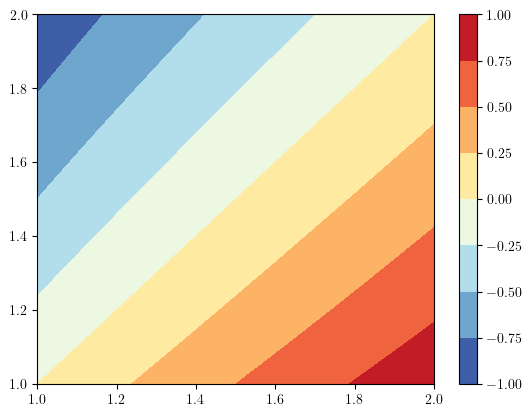

In [101]:
Z = eigfunc2
Z = Z.reshape(100,100)
# Z = Z/np.max(np.abs(Z))
h = plt.contourf(X,Y,Z,cmap='RdYlBu_r')
plt.colorbar(h)

In [102]:
np.isclose(koopman_eigen_edmd.left_koopman_eigvals,edmd_poly.koopman_eigenvalues).all()

True

It works for diffeo(x) = x^2

In [103]:
np.max(x_flat), np.min(x_flat)

(2.0, 1.0)

In [104]:
(koopman_eigenfunctions_eval[:,3] - (eigfunc1**5))

array([ -0.04697925+0.j,  -0.04673667+0.j,  -0.04650297+0.j, ...,
       -21.94912112+0.j, -21.94841036+0.j, -21.94770468+0.j])

In [105]:
np.isclose(eigfunc1, eigenfunction_j(diffeo_inv(x_flat)[:,0], diffeo_inv(x_flat)[:,1])).all()

True

In [106]:
np.isclose(eigfunc2, eigenfunction_i(diffeo_inv(x_flat)[:,0], diffeo_inv(x_flat)[:,1])).all()

True

In [107]:
sorted_eig = linear_system_c.get_sorted_eigvalues(max_exponent_sum=5)
sorted_eig

[(0, 2),
 (1, 1),
 (0, 4),
 (2, 0),
 (1, 3),
 (2, 2),
 (3, 1),
 (4, 0),
 (5, 0),
 (4, 1),
 (3, 2),
 (2, 3),
 (3, 0),
 (1, 4),
 (2, 1),
 (0, 5),
 (1, 2),
 (0, 3),
 (1, 0),
 (0, 1)]

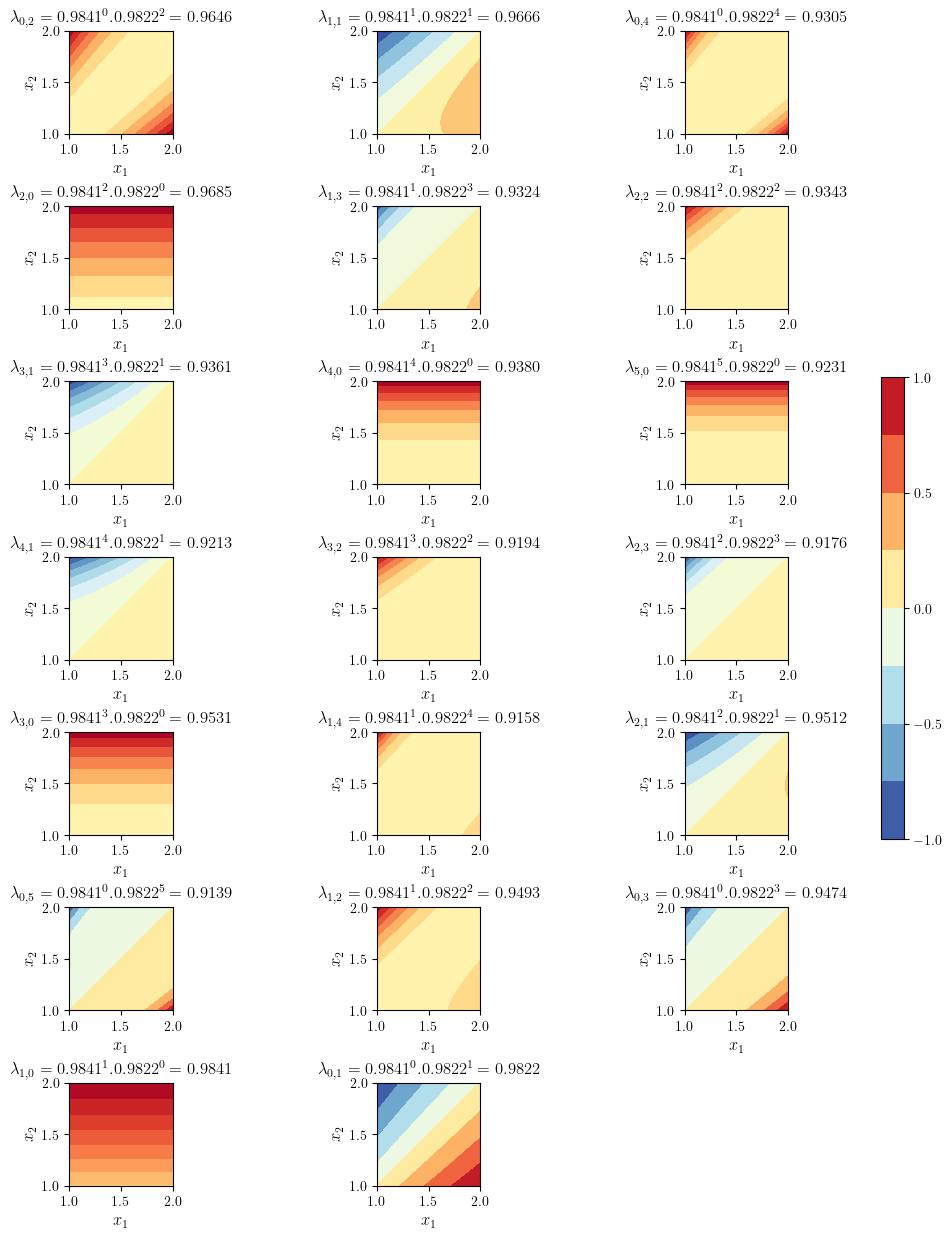

In [270]:
f, ax = plt.subplots(len(sorted_eig)//3 + 1, 3, figsize=(15, 15))
f.delaxes(ax[len(sorted_eig)//3, 2])
plt.subplots_adjust(hspace=0.7, wspace=0.1)

# define grid range
x = np.linspace(1, 2, 100)
y = np.linspace(1, 2, 100)
X, Y = np.meshgrid(x, y)
x_flat = np.array([X.flatten(), Y.flatten()]).T
    
for i, (m,n) in enumerate(sorted_eig):
    X, Y = np.meshgrid(x, y)
    eigfunc1 = diffeo_inv(x_flat) @ eigvecs_A[:,0]
    eigfunc2 = diffeo_inv(x_flat) @ eigvecs_A[:,1]
    
    Z = (eigfunc1**m) * (eigfunc2**n)
    
    Z = Z.reshape(100,100)
    
#     if normalize:
    Z = Z/np.max(np.abs(Z))

    h = ax[int(i/3)][i%3].contourf(X, Y, Z, cmap='RdYlBu_r', vmin=-1, vmax=1)
    ax[int(i/3)][i%3].set_xticks([ax[int(i/3)][i%3].get_xlim()[0], 1.5, ax[int(i/3)][i%3].get_xlim()[1]])
    ax[int(i/3)][i%3].set_yticks([ax[int(i/3)][i%3].get_ylim()[0], 1.5, ax[int(i/3)][i%3].get_ylim()[1]])
    ax[int(i/3)][i%3].set_aspect('equal')
    ax[int(i/3)][i%3].set_xlabel("$x_1$", fontsize=12)
    ax[int(i/3)][i%3].set_ylabel("$x_2$", fontsize=12)
    
#     linear_system_c.plot_eigenfunction_contour(x=x, y=y, m=m, n=n, ax = ax[int(i/3)][i%3])
    eig = (np.exp(eigs_A[0] * t_sample))**m * (np.exp(eigs_A[1] * t_sample)) ** n
    eig_str = f"$\lambda_{{{m},{n}}} = {np.exp(eigs_A[0] * t_sample):.4}^{m} . {np.exp(eigs_A[1] * t_sample):.4}^{n} = {eig:0.4f}$"
    ax[int(i/3)][i%3].set_title(eig_str, fontsize=12)

cbar = f.colorbar(h, ax=ax.ravel().tolist(), shrink=0.4, pad=0.08)
cbar.ax.tick_params(labelsize=10)
cbar.set_ticks(np.arange(-1, 1.1, 0.5))

plt.savefig(f"plots/{nb_fname}/diffeo_linear_continuous_system_explicit_eigefuncs.pdf", bbox_inches='tight', dpi=300)
plt.show()

### calculating $\epsilon_G$

In [138]:
x = np.linspace(1, 2, 100)
y = np.linspace(1, 2, 100)
X, Y = np.meshgrid(x, y)

x_flat = np.array([X.flatten(), Y.flatten()]).T
print(x_flat.shape)

(10000, 2)


In [139]:
t_sample

0.02

In [140]:
# step size for euler integration
h = 0.001

#### calculating eps_G over grid for euler method

In [141]:
def get_euler_eps_G(x, h, t_sample):

    x_euler = np.apply_along_axis(lambda x: linear_system_c.euler_method(x, t_sample, h=h), 1, x)
    x_exact = (ln.expm(A*t_sample) @ (x.T)).T

    y_euler = diffeo(x_euler)
    y_exact = diffeo(x_exact)

    epsilon_x = x_euler - x_exact
    epsilon_y = y_euler - y_exact
    epsilon_G = np.apply_along_axis(lambda x: np.linalg.norm(x), 1, epsilon_y).max()
    return epsilon_G

In [142]:
get_euler_eps_G(x_flat, h, t_sample)

0.0019399677971119495

In [143]:
for i in koopman_eigen_rbf.left_koopman_eigvals:
    for j in koopman_eigen_rbf.left_koopman_eigvals:
        if i < 1e-10 or j <1e-10:
            continue
        if np.isclose(i, j**2, atol=1e-06):
            print(i,j, 2)
        if np.isclose(i, j**3, atol=1e-06):
            print(i,j,3)
        if np.isclose(i, j**4, atol=1e-06):
            print(i,j,4)
        if np.isclose(i, j**5, atol=1e-06):
            print(i,j,5)
        if np.isclose(i, j**6, atol=1e-06):
            print(i,j,5)
        if np.isclose(i, j**7, atol=1e-06):
            print(i,j,5)

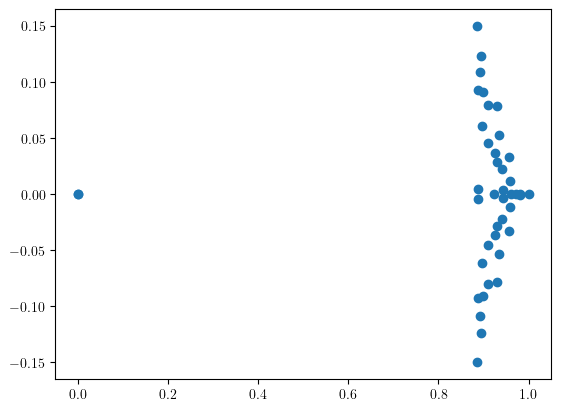

In [144]:
f,ax = plt.subplots(1,1)

ax.scatter(koopman_eigen_rbf.left_koopman_eigvals.real, koopman_eigen_rbf.left_koopman_eigvals.imag)
# ax.set(xlim=(-1, 1), ylim=(-6, 6))

In [145]:
koopman_eigen_rbf.koopman_matrix.shape

(42, 42)

In [146]:
h, x_flat.max(), x_flat.min()

(0.001, 2.0, 1.0)

In [147]:
eps_G = get_euler_eps_G(x_flat, h=0.0001, t_sample=t_sample)
eps_G

0.00019384112878902132

#### define nonlinear system explicitly

In [148]:
from koopmaneigen.nonlinearsystem import NonLinear2dSystem

def F(t, y):
    return np.diag(1-np.exp(-y)) @ A @ np.log(np.exp(y) -1)

def explicit_sol(x1, x2, t):
    
    x = np.array([x1,x2]).T
    x = diffeo_inv(x)
        
    x_exact = (ln.expm(A*t_sample) @ (x.T))

    y_exact = diffeo(x_exact)
    
    return y_exact

nonlin_system = NonLinear2dSystem(F, explicit_sol)

### Run eigenvalue solver

In [149]:
from koopmaneigen.matrix_eigsolver import MatrixEigSolver

In [150]:
matrix_eigsolver = MatrixEigSolver(koopman_eigen_rbf.koopman_matrix)

In [152]:
eigs, left_eigs = matrix_eigsolver.power_iteration_with_deflation_asymm_complex(num_eigen=9, tolerance=1e-7)

eigenvalue 1
max iter reached in power method 0.0
tol achieved in 1 iterations
max iter reached in power method 0.0
tol achieved in 2 iterations
lambda:  (0.9999344859266437+0j)
---------------------------------
eigenvalue 2
max iter reached in power method 0j
tol achieved in 58516 iterations
max iter reached in power method 0j
tol achieved in 73954 iterations
lambda:  (0.9819817670582345+0.0003168096405868695j)
---------------------------------
eigenvalue 3
max iter reached in power method 0j
tol achieved in 1387 iterations
max iter reached in power method 0j
tol achieved in 467 iterations
lambda:  (0.971688386430632-1.369938435052953e-07j)
---------------------------------
eigenvalue 4
max iter reached in power method 0j
tol achieved in 8254 iterations
max iter reached in power method 0j
tol achieved in 5874 iterations
lambda:  (0.9613189043620851-2.5009244369877948e-08j)
---------------------------------
eigenvalue 5
max iter reached in power method 0j
tol achieved in 4387 iteration

In [153]:
left_eigs[2][1] == left_eigs[3][1].conj()

False

In [154]:
koopman_eigen_rbf.left_koopman_eigvals

array([ 9.99934503e-01+0.j        ,  9.81981812e-01+0.00031697j,
        9.81981812e-01-0.00031697j,  9.71688033e-01+0.j        ,
        9.61318889e-01+0.j        ,  9.59085571e-01+0.01174639j,
        9.59085571e-01-0.01174639j,  9.56060982e-01+0.03288086j,
        9.56060982e-01-0.03288086j,  9.43692058e-01+0.00374694j,
        9.43692058e-01-0.00374694j,  9.40828449e-01+0.02258207j,
        9.40828449e-01-0.02258207j,  9.34234921e-01+0.05314323j,
        9.34234921e-01-0.05314323j,  9.29444311e-01+0.02835104j,
        9.29444311e-01-0.02835104j,  9.28991924e-01+0.07828018j,
        9.28991924e-01-0.07828018j,  9.25322772e-01+0.03683602j,
        9.25322772e-01-0.03683602j,  9.23963013e-01+0.j        ,
        9.10139521e-01+0.07986067j,  9.10139521e-01-0.07986067j,
        9.09919835e-01+0.04539766j,  9.09919835e-01-0.04539766j,
        9.00047885e-01+0.09108203j,  9.00047885e-01-0.09108203j,
        8.96640605e-01+0.06119983j,  8.96640605e-01-0.06119983j,
        8.94946505e-01+0.

In [155]:
[e[1] for e in eigs]

[(0.9999344859266437+0j),
 (0.9819817670582345+0.0003168096405868695j),
 (0.9819817670582345-0.0003168096405868695j),
 (0.971688386430632-1.369938435052953e-07j),
 (0.9613189043620851-2.5009244369877948e-08j),
 (0.9590842774296544+0.011748053154415104j),
 (0.9590842774296544-0.011748053154415104j),
 (0.9560610559684621+0.03288090816423525j),
 (0.9560610559684621-0.03288090816423525j)]

In [156]:
## based on this calculated eigenfunction calculate trajectory errors for its power

In [157]:
# calculate upper bound given tolerance for trajectory error(epsilon)

In [158]:
x = np.linspace(1, 2, 200)
y = np.linspace(1, 2, 200)
X, Y = np.meshgrid(x, y)

x_flat = np.array([X.flatten(), Y.flatten()]).T
print(x_flat.shape)

(40000, 2)


In [159]:
koopman_eigen_rbf.eigenfunction_left(left_eigs[0][0])(x_flat).max()

(0.006147772188012753+0j)

In [160]:
# get eps_G
t_eval = np.linspace(0,0.4,21)
t_eval

eps_G = nonlin_system.get_euler_eps_G(x_flat, t_eval, integration_method="RK45")
eps_G

3.6724951936049013e-09

In [161]:
# bound and error for first eigenpair
for e in left_eigs:
    eig = e[1]
    eigvec = e[0]
    eigfunc = koopman_eigen_rbf.eigenfunction_left(eigvec)
    print(eig)
#     print(np.abs(eigfunc(x_flat).max()))
    for p in range(1,4):
        traj_error = nonlin_system.trajectory_error_power_eigvec(x_flat, koopman_eigen_rbf, eigvec,
                                            eig, p=p, t_eval=t_eval, integration_method="RK45")
                
        traj_error_bound = nonlin_system.trajectory_bound_integration(koopman_eigen_rbf, x_flat, p=p, 
                                                                      epsilon_G=eps_G, eigvalue=eig)    
    
        print(p, traj_error, traj_error_bound)

    print("--------------")
#     break

(0.9999345027012122+0j)
1 9.201116406203062e-08 (1.6434956506827803e-08+0j)
2 3.3602446046408625e-05 (0.0003797811335761755+0j)
3 0.00021822368280363956 (0.009828232425480341+0j)
--------------
(0.9819818524776525+0.0003169090567616273j)
1 1.4769930076483926e-07 (1.6434956506827803e-08+0j)
2 4.085239664313288e-05 (0.00037635643814039224+6.072961572548513e-08j)
3 0.0002624145562608154 (0.009710241473284753+2.0891516066689843e-06j)
--------------
(0.9819818524776525-0.0003169090567616273j)
1 1.4769930076483926e-07 (1.6434956506827803e-08+0j)
2 4.085239664313288e-05 (0.00037635643814039224-6.072961572548513e-08j)
3 0.0002624145562608154 (0.009710241473284753-2.0891516066689843e-06j)
--------------
(0.9716880071272174-1.4007296794682489e-08j)
1 8.78329305277349e-08 (1.6434956506827803e-08+0j)
2 1.17119478862839e-05 (0.00037437861482653146-2.6984136111784922e-12j)
3 5.811547395914348e-05 (0.009642262370436108-9.266488059933975e-11j)
--------------
(0.9613188723354968-3.853851965329724e-08j)

In [164]:
nonlin_system.trajectory_bound_integration(koopman_eigen_rbf, x_flat, p=2, epsilon_G=eps_G, 
                             eigvalue=left_eigs[0][1])

(0.0003797811335761755+0j)

In [165]:
# trajectory error for euler integration over linear system
def trajectory_error_eigpair(koopman_eigen, eig, eigvec, p, x):
    eigfunc = koopman_eigen.eigenfunction_left(eigvec)
    # should you use euler integration or use some other integration so that eps_G can be smaller
    x_euler = np.apply_along_axis(lambda x: linear_system_c.euler_method(diffeo_inv(x), t_sample, h=h), 1, x)

    return np.linalg.norm((eigfunc(diffeo(x_euler))**p) - (eig**p)*(eigfunc(x))**p)/np.sqrt(x.shape[0])
#     return np.linalg.norm((eigfunc(diffeo(x_euler))**p) - 10*(eigfunc(x))**p)/np.sqrt(x.shape[0])

In [166]:
trajectory_error_eigpair(koopman_eigen_rbf, left_eigs[0][1], left_eigs[0][0], p=1, x=x_flat)

8.849860514342768e-08

#### Check how many extended eigenfunctions we get with the cutoff of trajectory error and based on trajectory error upper bound

In [167]:
x = np.linspace(1, 2, 100)
y = np.linspace(1, 2, 100)
X, Y = np.meshgrid(x, y)

x_flat = np.array([X.flatten(), Y.flatten()]).T
print(x_flat.shape)

(10000, 2)


In [168]:
x_flat.max(), x_flat.min()

(2.0, 1.0)

In [169]:
#### get eps_G of euler method 

In [170]:
h =0.0001
euler_eps_G = get_euler_eps_G(x_flat, h, t_sample=t_sample)

In [171]:
# get eps_G
t_eval = np.linspace(0,0.4,21)
t_eval

eps_G = nonlin_system.get_euler_eps_G(x_flat, t_eval, integration_method="RK45")
eps_G

3.6724951936049013e-09

In [172]:
# set desired upper bound for trajectory error
epsilon = 0.01

In [173]:
len(left_eigs)

9

In [174]:
left_eigs[0][1]

(0.9999345027012122+0j)

In [175]:
algorithm_list = []
extendable_list = []
print("$\epsilon_G$=", eps_G)
print("desired epsilon= ", epsilon)

print(x_flat.shape)

for i, e in enumerate(left_eigs):
    eig = e[1]
    eigvec = e[0]
    print("eig: ", eig)
    
    for p in range(1, 11):

        bound_for_E_g = nonlin_system.trajectory_bound_given_epsilon(koopman_eigen_rbf, x_flat, p=p, epsilon=epsilon, 
                                                                     eigvalue=eig)

        etg = nonlin_system.trajectory_error_power_eigvec(x_flat, koopman_eigen_rbf, eigvec,
                                                          eig, p=p, t_eval=t_eval, integration_method="RK45")
        
        print("p: ", p, etg, "bound: ", bound_for_E_g, "eps_G < bound: ", eps_G < bound_for_E_g, "traj_error < epsilon: ", etg < epsilon)

        algorithm_list.append({"eig": eig, "p":p, "algo_upper_bound": bound_for_E_g, "traj_error" : etg})
        
        if eps_G < bound_for_E_g and etg <epsilon:
            extendable_list.append({"eig": eig, "p":p, "algo_upper_bound": bound_for_E_g, 
                                    "traj_error" : etg, "eig_index": i})

    print("-----------------\n")


$\epsilon_G$= 3.6724951936049013e-09
desired epsilon=  0.01
(10000, 2)
eig:  (0.9999345027012122+0j)
p:  1 9.198232498625834e-08 bound:  (0.002234586493939342+0j) eps_G < bound:  True traj_error < epsilon:  True
p:  2 3.3597129928597365e-05 bound:  (2.5462381771009318e-06+0j) eps_G < bound:  True traj_error < epsilon:  True
p:  3 0.00021820045297439586 bound:  (3.868483551873647e-09+0j) eps_G < bound:  True traj_error < epsilon:  True
p:  4 0.0005399388634729545 bound:  (6.612066365149507e-12+0j) eps_G < bound:  False traj_error < epsilon:  True
p:  5 0.0009179784291372942 bound:  (1.2106740155309016e-14+0j) eps_G < bound:  False traj_error < epsilon:  True
p:  6 0.0012987827067647137 bound:  0j eps_G < bound:  False traj_error < epsilon:  True
p:  7 0.0016574278753729726 bound:  0j eps_G < bound:  False traj_error < epsilon:  True
p:  8 0.0019849019420636756 bound:  0j eps_G < bound:  False traj_error < epsilon:  True
p:  9 0.0022797262775559467 bound:  0j eps_G < bound:  False traj_e

p:  5 0.00045824757993074856 bound:  (1.4488393956353414e-14+6.961995811646707e-16j) eps_G < bound:  False traj_error < epsilon:  True
p:  6 0.0006464497300203568 bound:  6.202223440219783e-18j eps_G < bound:  False traj_error < epsilon:  True
p:  7 0.0008254918210136027 bound:  3.1011117201098916e-18j eps_G < bound:  False traj_error < epsilon:  True
p:  8 0.0009906232002356624 bound:  (1.9847115008703306e-16+1.5505558600549458e-18j) eps_G < bound:  False traj_error < epsilon:  True
p:  9 0.001140736451551828 bound:  3.1011117201098916e-18j eps_G < bound:  False traj_error < epsilon:  True
p:  10 0.0012763746302521034 bound:  (1.9847115008703306e-16+1.5505558600549458e-18j) eps_G < bound:  False traj_error < epsilon:  True
-----------------

eig:  (0.9560610899767945+0.03288085535220031j)
p:  1 8.241236225118796e-08 bound:  (0.002234586493939342+0j) eps_G < bound:  True traj_error < epsilon:  True
p:  2 8.287877820353128e-06 bound:  (2.6599379294449523e-06-9.148033224490024e-08j) eps_

In [678]:
len(extendable_list)

27

In [679]:
extendable_list

[{'eig': (0.9999345033709429+0j),
  'p': 1,
  'algo_upper_bound': (0.002234586493939342+0j),
  'traj_error': 9.198212978270109e-08,
  'eig_index': 0},
 {'eig': (0.9999345033709429+0j),
  'p': 2,
  'algo_upper_bound': (2.5462381755131626e-06+0j),
  'traj_error': 3.359709194684855e-05,
  'eig_index': 0},
 {'eig': (0.9999345033709429+0j),
  'p': 3,
  'algo_upper_bound': (3.868483551873647e-09+0j),
  'traj_error': 0.00021820027841942314,
  'eig_index': 0},
 {'eig': (0.9819818184377418-0.00031701307436619863j),
  'p': 1,
  'algo_upper_bound': (0.002234586493939342+0j),
  'traj_error': 1.4767462000342098e-07,
  'eig_index': 1},
 {'eig': (0.9819818184377418-0.00031701307436619863j),
  'p': 2,
  'algo_upper_bound': (2.592788349077051e-06+8.370273024549053e-10j),
  'traj_error': 4.085677182048633e-05,
  'eig_index': 1},
 {'eig': (0.9819818184377418-0.00031701307436619863j),
  'p': 3,
  'algo_upper_bound': (4.011223010660491e-09+2.589885651815605e-12j),
  'traj_error': 0.0002625173887198239,
  '

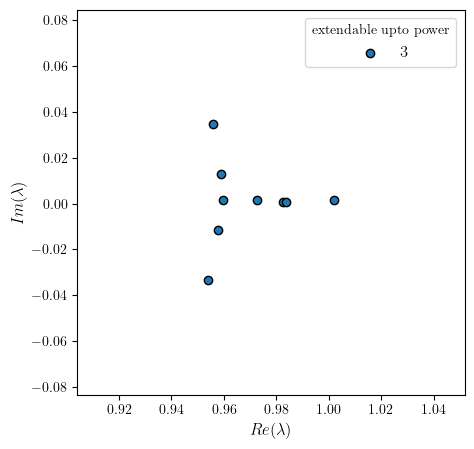

In [179]:
f,ax = plt.subplots(1,1, figsize=(5,5))

jitter_amount = 0.002  # Adjust this value to control the amount of jitter
e_imag = [e[1].imag for e in left_eigs]
e_real = [e[1].real for e in left_eigs]
e_extendable = []
for i in range(len(left_eigs)):
    e_extendable.append(max([e["p"] for e in extendable_list if e["eig_index"] == i]))


x_jittered = e_real + np.random.uniform(-jitter_amount, jitter_amount, len(e_real))
y_jittered = e_imag + np.random.uniform(-jitter_amount, jitter_amount, len(e_imag))


for p in np.unique(e_extendable):
    
    ax.scatter(x_jittered[np.where(np.array(e_extendable) == p)[0]], 
               y_jittered[np.where(np.array(e_extendable) == p)[0]], 
               label=p, edgecolor="black")

ax.set(xlim=(min(x_jittered) - 0.05, max(x_jittered) + 0.05), 
       ylim=(min(y_jittered) - 0.05, max(y_jittered) + 0.05))

ax.set_xlabel("$Re(\lambda)$", fontsize=12)
ax.set_ylabel("$Im(\lambda)$", fontsize=12)
plt.legend(title="extendable upto power", fontsize=12)

plt.savefig(f"plots/{nb_fname}/diffeo_linear_extendable_EDMD_spectrum.pdf", bbox_inches='tight', dpi=300)
plt.show()

In [180]:
### 10 eigs and upto 3 powers of each are extendable

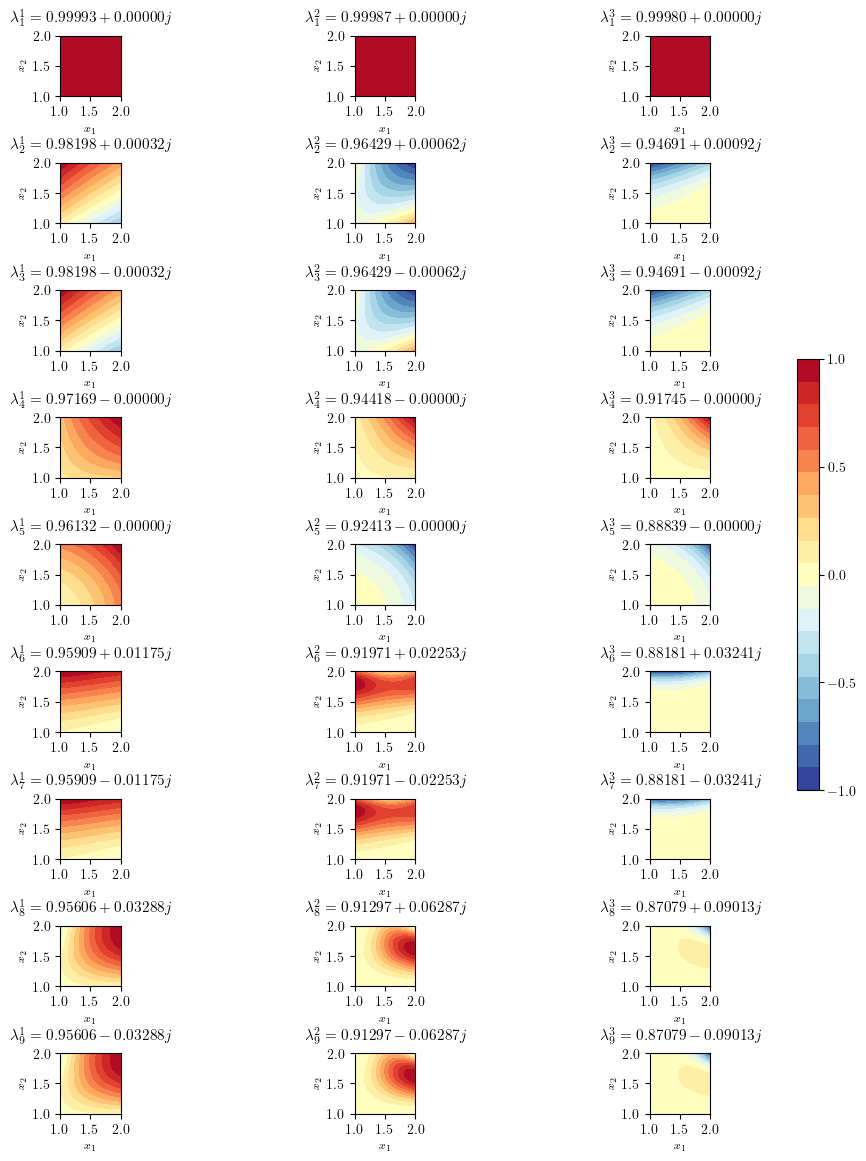

In [269]:
f, ax = plt.subplots(len(left_eigs), max([e["p"] for e in extendable_list]), figsize=(14, 14))
plt.subplots_adjust(hspace=1.1)

x = np.linspace(1, 2, 100)
y = np.linspace(1, 2, 100)
X, Y = np.meshgrid(x, y)
x_flat = np.array([X.flatten(), Y.flatten()]).T

koopman_eigenfunctions_eval = koopman_eigen_rbf.eigenfunction_left(koopman_eigen_rbf.left_koopman_eigvecs)(x_flat)

for i in range(len(left_eigs)):
    
    eigfunc = koopman_eigen_rbf.eigenfunction_left(left_eigs[i][0])(x_flat)
    
    for p in [e["p"] for e in extendable_list if e["eig_index"] == i]:
    
        Z = (eigfunc ** p)
        Z = Z.reshape(100,100)
        Z = Z.real
        Z = Z/np.max(np.abs(Z))
    
        h = ax[i][p-1].contourf(X, Y, np.array(Z).reshape(100,100), cmap='RdYlBu_r',
                                levels=np.linspace(-1, 1, 20))
        
        eig = left_eigs[i][1] ** p

        ax[i][p-1].set_title(f"$\lambda_{i+1}^{p} = {eig:.5f}$", fontsize=11, pad=10)
        ax[i][p-1].set_aspect("equal")
        ax[i][p-1].set_xlabel("$x_1$", fontsize=8)
        ax[i][p-1].set_ylabel("$x_2$", fontsize=8)
        ax[i][p-1].set_xticks([ax[i][p-1].get_xlim()[0], 1.5, ax[i][p-1].get_xlim()[1]])
        ax[i][p-1].set_yticks([ax[i][p-1].get_ylim()[0], 1.5, ax[i][p-1].get_ylim()[1]])
#         plt.colorbar(h)

cbar = f.colorbar(h, ax=ax.ravel().tolist(), shrink=0.4, pad=0.08)
cbar.ax.tick_params(labelsize=10)
cbar.set_ticks(np.arange(-1, 1.1, 0.5))

plt.savefig(f"plots/{nb_fname}/EDMD_rbf_40_algorithm_8_extended_eigfuncs.pdf", bbox_inches='tight', dpi=300)
plt.show()

f,ax = plt.subplots(1,2, figsize=(12,4))

m_list = [a["m"] for a in algorithm_list if a["n"]==0]
m_etg =  [a["traj_error"] for a in algorithm_list if a["n"]==0]
m_upper = [a["algo_upper_bound"] for a in algorithm_list if a["n"]==0]
ax[0].scatter(m_list, np.log10(m_etg), label=r"$E_{TG}(\bar{\phi}_p, p)$", s=20)
ax[0].scatter(m_list, np.log10(m_upper), label=r"$\frac{1}{L} [(\epsilon + (\bar{\lambda}_q M)^p)^{1/p} - \bar{\lambda}_q M]$", c="orange")
ax[0].axhline(np.log10(epsilon), linestyle = '--', c="black", label=r"$\epsilon$")
ax[0].axhline(np.log10(epsilon_G), linestyle = '--', c="red", label=r"$\epsilon_G$")
ax[0].set_ylabel("$log_{10}$")
ax[0].set_xlabel("p")
ax[0].set_xticks(m_list)
ax[0].legend()

n_list = [a["n"] for a in algorithm_list if a["m"]==0]
n_etg =  [a["traj_error"] for a in algorithm_list if a["m"]==0]
n_upper = [a["algo_upper_bound"] for a in algorithm_list if a["m"]==0]
ax[1].scatter(n_list, np.log10(n_etg), label=r"$E_{TG}(\bar{\phi}_q, q)$", s=20)
ax[1].scatter(n_list, np.log10(n_upper), label=r"$\frac{1}{L} [(\epsilon + (\bar{\lambda}_q M)^q)^{1/q} - \bar{\lambda}_q M]$", c="orange")
ax[1].axhline(np.log10(epsilon), linestyle = '--', c="black",  label=r"$\epsilon$")
ax[1].axhline(np.log10(epsilon_G), linestyle = '--', c="red", label=r"$\epsilon_G$")
ax[1].set_ylabel("$log_{10}$")
ax[1].set_xlabel("q")
ax[1].set_xticks(n_list)
ax[1].legend()


f.suptitle("Finding powers for extending eigenpairs given $\epsilon=1$ with integration error $\epsilon_G$")
# plt.savefig('plots/algorithm_eps_10_eps_G_DMD_eigfunc_extend_cont.png', bbox_inches='tight')

plt.show()


### sampling from explicit system

In [589]:
initial_conditions_diffeo  = diffeo(initial_conditions)

t_eval = np.linspace(0, 0.4, 21)
t_sample = t_eval[-1]/(t_eval.shape[0]-1)

non_lin_tsc_data = nonlin_system.sample_system(initial_conditions_diffeo, t_sample)
print(f"time delta: {non_lin_tsc_data.delta_time}")
print(f"#time series: {non_lin_tsc_data.n_timeseries}")
print(f"#time steps per time series: {non_lin_tsc_data.n_timesteps}")
print(f"(n_samples, n_features): {non_lin_tsc_data.shape}")
print(f"time interval {non_lin_tsc_data.time_interval()}")
print(f"Same time values: {non_lin_tsc_data.is_same_time_values()}")
print("")
print("Data snippet:")
non_lin_tsc_data.head()

time delta: 0.02
#time series: 900
#time steps per time series: 2
(n_samples, n_features): (1800, 2)
time interval (0.0, 0.02)
Same time values: True

Data snippet:


feature        x1        x2
ID time                    
0  0.00  0.693147  0.693147
   0.02  0.693147  0.693147
1  0.00  0.693147  0.728224
   0.02  0.693215  0.727658
2  0.00  0.693147  0.764489

In [591]:
np.linalg.norm(tsc_data_nonlin - non_lin_tsc_data)

5.710907813144177e-15

In [77]:
t_eval = np.linspace(0,0.4,21)
t_eval

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 ])

In [81]:
# calculating epsilon_G using "RK45" integration instead of euler method
nonlin_system.get_euler_eps_G(x_flat, t_eval)

3.6724951936049013e-09

In [104]:
nonlin_system.trajectory_error_power_eigvec(x_flat, koopman_eigen_rbf, eigvec=left_eigs[0][0],
                                            eig=left_eigs[0][1], p=1, t_eval=t_eval, integration_method="RK45")

9.197907372615094e-08

#### RBF with gaussian kernel formula

In [149]:
from scipy.spatial.distance import cdist, pdist, squareform

distance_mat = cdist(tsc_data_nonlin, centers, metric="sqeuclidean")
kernel_mat = np.exp((-1/(2* edmd_rbf.named_steps["rbf"].kernel.epsilon)) * distance_mat)
kernel_mat.shape

np.array(edmd_rbf.transform(tsc_data_nonlin))[:,2:]

# formula for rbf gaussian kernel is 
# x sample and c center
# exp(-1/(2eps) * ||x-c||^2)

(np.array(edmd_rbf.named_steps["rbf"].centers_)  == centers).all()

np.isclose(np.array(edmd_rbf.transform(tsc_data_nonlin))[:,2:], kernel_mat).all()

True

In [151]:
def trajectory_error_euler(koopman_eigen, x, p, h=0.01, eigenvector_index=0, delv_norm=None):  
    """Compute trajectory error for extended eigenfunction


    Args:
        koopman_eigen (KoopmanEigen): object of koopman eigen
        x (_type_): values of grid coordinates
        p (_type_): power
        h (float): euler method step size
        eigenvector_index (int, optional): Eigenvector index to use for extending eigenfunction. Defaults to 0.
        delv_norm (float, optional): norm of error vector added to left eigenvectors. Defaults to None
    """
    assert x.shape[1] == 2


    Z_l = koopman_eigen.extend_eigenfunctions(x, eigenvector_indexes=[eigenvector_index, 0], pow_i=p, pow_j=0, normalize=False)

    x_euler = np.apply_along_axis(lambda x: linear_system_c.euler_method(diffeo_inv(x), t_sample, h=h), 1, x)
    
    x_euler_diffeo = diffeo(x_euler)

    Z_l_t = koopman_eigen.extend_eigenfunctions(x_euler_diffeo, eigenvector_indexes=[eigenvector_index, 0], pow_i=p, pow_j=0, normalize=False)

    eig_c = koopman_eigen.left_koopman_eigvals[eigenvector_index]**p
    traj_error_euler = np.linalg.norm(Z_l_t - eig_c*Z_l)/np.sqrt(x.shape[0])
    return traj_error_euler



In [161]:
# trajectory error for euler integration over linear system
def trajectory_error_eigpair(koopman_eigen, eig, eigvec, p, x):
    eigfunc = koopman_eigen.eigenfunction_left(eigvec)
    # should you use euler integration or use some other integration so that eps_G can be smaller
    x_euler = np.apply_along_axis(lambda x: linear_system_c.euler_method(diffeo_inv(x), t_sample, h=h), 1, x)

    return np.linalg.norm((eigfunc(diffeo(x_euler))**p) - (eig**p)*(eigfunc(x))**p)/np.sqrt(x.shape[0])
#     return np.linalg.norm((eigfunc(diffeo(x_euler))**p) - 10*(eigfunc(x))**p)/np.sqrt(x.shape[0])